# Import useful libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/prescriber-info.csv')

In [3]:
# Clean State
rare_abbrev = df.groupby('State').size().where(lambda x: x < 10).dropna().index.tolist()
df['State'] = df['State'].apply(lambda x: 'other' if x in rare_abbrev else x)

In [4]:
# Group Credentials into 6 large categories
df['Credentials'] = df['Credentials'].apply(lambda x: str(x).replace('(', '').replace(')', '').replace('.', '').replace(' ', ''))
new_credentials = pd.Series('Other', index=df.index)
new_credentials.loc[df['Credentials'].apply(lambda x: 'MD' in x)] = 'MD'
new_credentials.loc[df['Credentials'].apply(lambda x: 'DDS' in x)] = 'DDS'
new_credentials.loc[df['Credentials'].apply(lambda x: 'DO' in x)] = 'DO'
new_credentials.loc[df['Credentials'].apply(lambda x: 'NP' in x or 'APRN' in x or 'NURSEPRACTITIONER' in x)] = 'NP'
new_credentials.loc[df['Credentials'].apply(lambda x: 'PA' in x or 'PHYSICIANASSIST' in x)] = 'PA'
df['Credentials'] = new_credentials

In [5]:
# Get common specialties as specialties with more than 50 practitioners
common_specialties = df.groupby('Specialty').size().where(lambda x: x > 50).dropna().index.tolist()

new_specialties = pd.Series('other', index=df.index)
new_specialties[df['Specialty'].apply(lambda x: x in common_specialties)] = df['Specialty']
new_specialties[df['Specialty'].apply(lambda x: 'surg' in x.lower())] = 'Surgeon'
new_specialties[df['Specialty'].apply(lambda x: 'pain' in x.lower())] = 'Pain Management'
df['Specialty'] = new_specialties

In [6]:
df.drop(columns=['NPI', 'Opioid.Prescriber'], inplace=True)

In [7]:
opioids = pd.read_csv('../data/opioids.csv')
opioids = opioids[opioids.columns[0]].apply(lambda x: x.replace(' ', '.').replace('-', '.')).tolist()

df['Total.Prescriptions'] = df[df.columns[4:]].sum(axis=1)
df['Opioid.Prescriptions'] = df[list(set(opioids) & set(df.columns))].sum(axis=1)

df = df[['Gender', 'State', 'Credentials', 'Specialty', 'Opioid.Prescriptions', 'Total.Prescriptions']]

df.loc[:, 'Opioid.Prescription.Rate'] = df['Opioid.Prescriptions'] / df['Total.Prescriptions']

In [8]:
g = sns.FacetGrid(df, col='Credentials',  row="Specialty", sharex=False, sharey=False)
g = g.map(plt.scatter, "Total.Prescriptions", "Opioid.Prescriptions", edgecolor='w')
for axes in [ax for axlist in g.axes for ax in axlist]:
    axes.invert_xaxis()

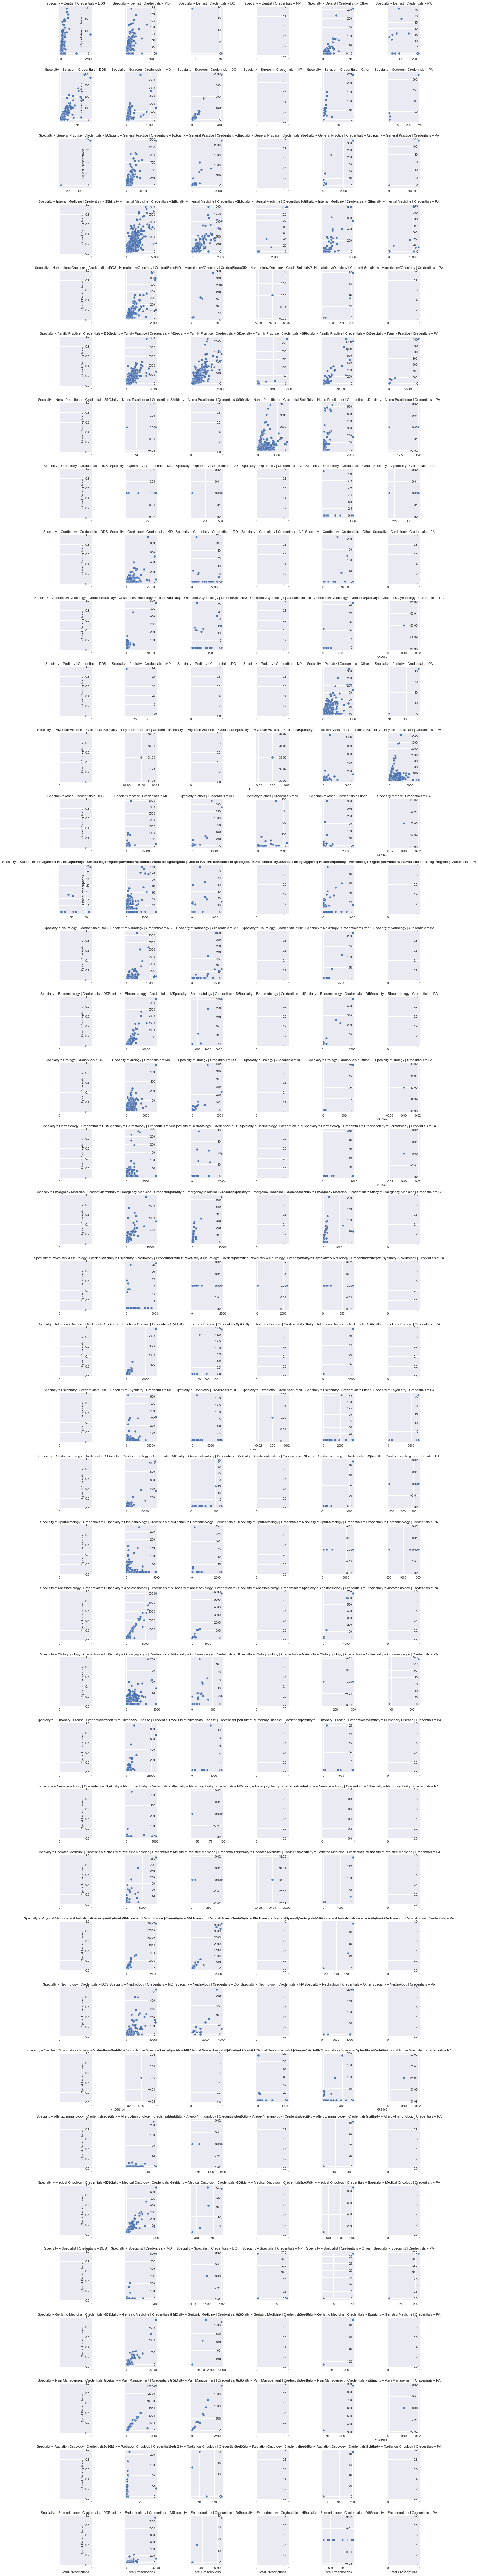

In [9]:
g.fig

In [10]:
g.savefig('../docs/facet.jpg')